In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import Flatten, Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#limit memory

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Loading the Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=(256, 256, 3),
)

In [4]:
# Summary of the model
base_model.summary()

                 
__________________________________________________________________________________________________
block5_sepconv1 (SeparableConv2 (None, 16, 16, 728)  536536      block5_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 16, 16, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 16, 16, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 16, 16, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 16, 16, 728)  2912        block5_sepconv2[0][0]     

In [5]:
# Making layers of base model untrainable so that their weights won't change during training for first few epochs
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Defining the input and output layers of the base model
base_input = base_model.layers[0].input
base_output = base_model.layers[-1].output

In [7]:
# Adding the output layers to the base model
l1 = Flatten()(base_output)
l2 = Dense(512, activation='elu')(l1)
l3 = Dropout(0.2)(l2)
l4 = Dense(256, activation='elu')(l3)
l5 = Dropout(0.2)(l4)
l6 = Dense(12, activation='softmax')(l5)

model = tf.keras.Model(inputs=base_input, outputs=l6)

In [8]:
#Importing the data and augmenting it:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.15,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'Dataset/OG_Train',
        target_size=(256, 256),
        batch_size=69,
        class_mode='categorical')


valid_datagen = ImageDataGenerator(rescale=1/255)

valid_generator = valid_datagen.flow_from_directory(
        'Dataset/OG_Valid',
        target_size=(256, 256),
        batch_size=17,
        class_mode='categorical')

Found 1740 images belonging to 12 classes.
Found 443 images belonging to 12 classes.


In [9]:
# Compiling the model i.e selecting the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [12]:
# training the model for few epoch so that the weights of pretrained layers don't change abruptly
history = model.fit(
      train_generator,
      steps_per_epoch=25,
      validation_data=(valid_generator), 
      callbacks=[checkpoint_cb, early_stoping_cb], 
      epochs=10,
      verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 27 steps
Epoch 1/10
11/25 [============>.................] - ETA: 19s - loss: 22.8741 - acc: 0.1507WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [13]:
# Making some layers of base model trainable 
for layer in base_model.layers[-6:-1]:
    layer.trainable = True

In [11]:
# Setting up the callbacks

# checkpoint_cb will save the model which will perform the best on validation set
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# early_stoping_cb will stop the model traning once it stops improving
early_stoping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
# Compiling the model i.e selecting the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

In [15]:
# training the model
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      validation_data=(valid_generator),  
      epochs=100,
      verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 27 steps
Epoch 1/100
10/10 [==============================] - 19s 2s/step - loss: 8.7608 - categorical_accuracy: 0.1934 - val_loss: 5.7067 - val_categorical_accuracy: 0.2144
Epoch 2/100
10/10 [==============================] - 15s 2s/step - loss: 6.3289 - categorical_accuracy: 0.2296 - val_loss: 3.9695 - val_categorical_accuracy: 0.2460
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 4.9402 - categorical_accuracy: 0.2783 - val_loss: 4.0524 - val_categorical_accuracy: 0.2460
Epoch 4/100
10/10 [==============================] - 23s 2s/step - loss: 3.9685 - categorical_accuracy: 0.3232 - val_loss: 4.4405 - val_categorical_accuracy: 0.2393
Epoch 5/100
10/10 [==============================] - 28s 3s/step - loss: 3.2996 - categorical_accuracy: 0.3435 - val_loss: 3.1676 - val_categorical_accuracy: 0.3002
Epoch 6/100
10/10 [==============================] - 21s 2s/step - loss: 2.8691 - c

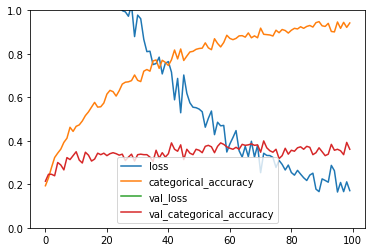

In [16]:
# Performance of the model on training and validation sets
pd.DataFrame(history.history).plot()
plt.gca().set_ylim(0, 1)
plt.show()

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs
